# P-tuning 实战

## P-Tuning原理

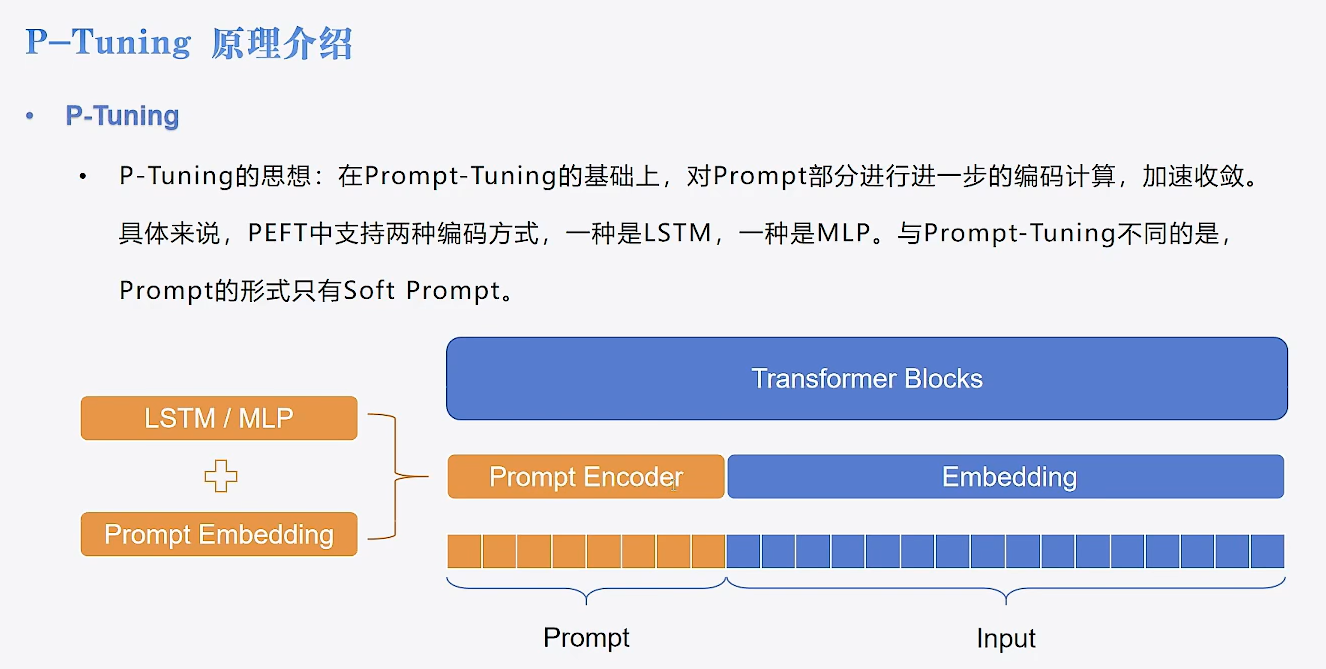

## Step1 导入相关包

In [1]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 加载数据集

In [2]:
ds = Dataset.load_from_disk("../data/alpaca_data_zh/")
ds

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})

In [3]:
ds[:3]

{'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。',
  '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。',
  '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。'],
 'input': ['', '输入：4/16', ''],
 'instruction': ['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']}

## Step3 数据集预处理

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-389m-zh")
tokenizer

BloomTokenizerFast(name_or_path='Langboat/bloom-389m-zh', vocab_size=42437, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [13]:
tokenized_ds = ds.map(process_func, remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})

In [ ]:
tokenizer.decode(tokenized_ds[1]["input_ids"])

In [ ]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

## Step4 创建模型

In [6]:
model = AutoModelForCausalLM.from_pretrained("Langboat/bloom-389m-zh", low_cpu_mem_usage=True)

## P-tuning

### PEFT Step1 配置文件

In [7]:
from peft import PromptEncoderConfig, TaskType, get_peft_model, PromptEncoderReparameterizationType

# 基础config
config = PromptEncoderConfig(task_type=TaskType.CAUSAL_LM,
                             num_virtual_tokens=10)

In [ ]:
from peft import PromptEncoderConfig, TaskType, get_peft_model, PromptEncoderReparameterizationType

config = PromptEncoderConfig(task_type=TaskType.CAUSAL_LM, 
                             num_virtual_tokens=10,
                             encoder_reparameterization_type=PromptEncoderReparameterizationType.MLP,  # 要使用的重新参数化类型
                             encoder_dropout=0.1, 
                             encoder_num_layers=5, encoder_hidden_size=1024)
config

### PEFT Step2 创建模型

In [8]:
model = get_peft_model(model, config)

In [9]:
config

PromptEncoderConfig(peft_type=<PeftType.P_TUNING: 'P_TUNING'>, auto_mapping=None, base_model_name_or_path='Langboat/bloom-389m-zh', revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, num_virtual_tokens=10, token_dim=1024, num_transformer_submodules=1, num_attention_heads=16, num_layers=24, encoder_reparameterization_type=<PromptEncoderReparameterizationType.MLP: 'MLP'>, encoder_hidden_size=1024, encoder_num_layers=2, encoder_dropout=0.0)

In [10]:
model.print_trainable_parameters()  # 要训练的参数

trainable params: 3,159,040 || all params: 348,928,000 || trainable%: 0.9053558327219369


## Step5 配置训练参数

In [11]:
args = TrainingArguments(
    output_dir="./chatbot",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

## Step6 创建训练器

In [14]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Step7 模型训练

In [15]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
trainer.train()

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,3.397500
20,3.133200


KeyboardInterrupt: 

## Step8 模型推理

In [16]:
model = model.cuda()
ipt = tokenizer("Human: {}\n{}".format("数学考试有哪些技巧？", "").strip() + "\n\nAssistant: ", return_tensors="pt").to(model.device)
print(tokenizer.decode(model.generate(**ipt, max_length=256, do_sample=True)[0], skip_special_tokens=True))

Human: 数学考试有哪些技巧？

Assistant: 数学考试有一年左右，在每年5月初至4月初进行，在每组试题中一般会出现4个以上或几个大题，而且题目大，易得分，因此，考生在考试之前需要做一些准备工作。
数学考试技巧包括：
（1）正确审题：对于大题进行审题，要认真审题，避免出现错选项、空格等现象，要使大题有条理，能准确的表述思路，让考试者有更好的针对性。
（2）提高答题速度：在审题的基础上进行快速答题，减少答题时出现各种错误。在快速答题中一定要注意准确把握分值，做到分数准确。
（3）正确整理题干：对大题进行整理的写作技巧主要是分值的大小、位置、数量及题干内容的简明扼要，考生在整理题干时应尽量使试题简明扼要。
（4）避免考点重叠：对于大题，考生在做题时要避免考点的纠错。考生在做题时要先确定要考点的点或难点，再根据题本身的特点在题干中具体描述出考点点或难点，做到答题
